In [258]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [259]:
def compute_distances_single_run(run, tid, n_threads):
    """
    np.array run:   1D array of integers resembling thread ID's in order of lock acquisitions
    int tid:        a given thread ID as integer for which to compute the gaps between lock acquisitions
    int n_threads:  the number of threads used for this run
    """
    indices = np.where(run == tid)[0] # np.where() returns a tuple
    if len(indices) > 0 and indices[0] > n_threads: 
        np.insert(indices,0,tid)
    return np.diff(indices).tolist()   

In [260]:
def count_frequencies_singe_run(run, tid):
    count = np.count_nonzero(run == tid)
    return count

In [261]:
def compute_gaps_and_freqs(data, n_threads, n_locks, total_runs):
    fair_share = n_locks/n_threads
    frequencies = []
    gaps = [] # stores all distances between occurences of the same thread ID for all threads and all runs
    for run in range(total_runs):
            for tid in range(n_threads):
                distances = compute_distances_single_run(data[run], tid, n_threads)
                frequencies.append(abs(fair_share - count_frequencies_singe_run(data[run], tid)))
                gaps += distances

    return frequencies, gaps

In [262]:
# Path to output files and list of output files
cwd = os.getcwd()
data_src = glob.glob(cwd + "/output/out_*")
file_names = [file_name.split('/')[-1] for file_name in data_src]

# Assign lock name to number according to convention
lock_dict = {1: 'omp', 2: 'filter', 3: 'tree', 4: 'block-woo'}

freq_dict = {}
gaps_dict = {}

for file in file_names:
    # Load one output file
    data = np.loadtxt(os.path.join(cwd + "/output", file), dtype=int)

    # Extract metadata from filename and data shape
    numbers = re.findall(r'\d+', file)
    n_threads = int(numbers[0])
    which_lock = int(numbers[1])
    n_locks = n_threads * n_threads
    total_runs = data.shape[0]

    # Print some metadata
    print(n_threads, "threads using", lock_dict[which_lock], "lock")
    print(total_runs, "runs with", data.shape[1], "lock acquisitions\n") 

    # Compute the fairness metrics
    frequencies, gaps = compute_gaps_and_freqs(data, n_threads, n_locks, total_runs)

    freq_dict[n_threads] = frequencies
    gaps_dict[n_threads] = gaps

8 threads using tree lock
30 runs with 64 lock acquisitions

2 threads using tree lock
30 runs with 4 lock acquisitions

4 threads using tree lock
30 runs with 16 lock acquisitions



Text(0, 0.5, 'waiting-for-lock period length')

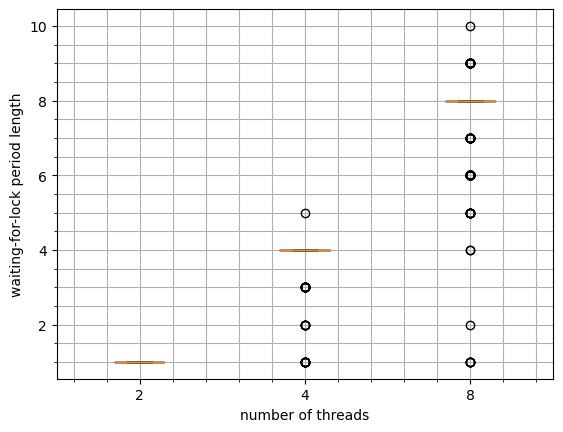

In [263]:
gaps_dict = dict(sorted(gaps_dict.items()))

fig, ax = plt.subplots()
ax.boxplot(gaps_dict.values())
ax.minorticks_on()
ax.grid(which="both")
ax.set_xticklabels(gaps_dict.keys())
ax.set_xlabel("number of threads")
ax.set_ylabel("waiting-for-lock period length")

Text(0, 0.5, 'deviation from fair lock distribution')

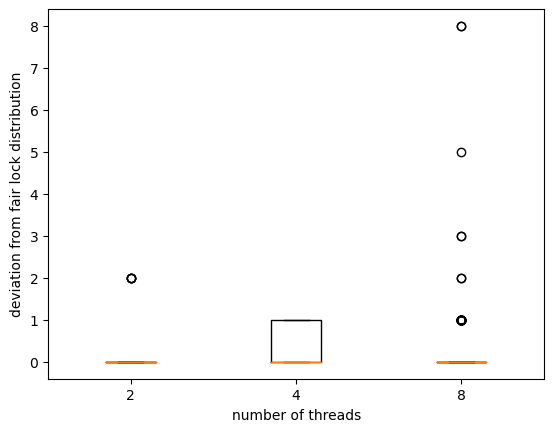

In [264]:
freq_dict = dict(sorted(freq_dict.items()))

fig, ax = plt.subplots()
ax.boxplot(freq_dict.values())
ax.set_xticklabels(gaps_dict.keys())
ax.set_xlabel("number of threads")
ax.set_ylabel("deviation from fair lock distribution")